In [1]:
import tensorflow as tf
print(tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))


2.18.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia --unzip

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
 99% 2.27G/2.29G [00:14<00:00, 339MB/s]
100% 2.29G/2.29G [00:14<00:00, 169MB/s]


In [3]:
!ls

chest_xray  sample_data


In [4]:
from numpy.random import seed
seed(101)
import tensorflow as tf

tf.random.set_seed(101)

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomContrast
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_curve, auc

import os
import cv2

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0, InceptionV3, ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras import Sequential

In [6]:
train_directory = "/content/chest_xray/train"
val_directory = "/content/chest_xray/val"
test_directory = "/content/chest_xray/test"

In [7]:
train_ds = keras.utils.image_dataset_from_directory(
    directory=train_directory,
    labels="inferred",
    label_mode="int",
    batch_size=32,
    image_size=(128, 128),
    seed=101
)

validation_ds = keras.utils.image_dataset_from_directory(
    directory=val_directory,
    labels="inferred",
    label_mode="int",
    batch_size=32,
    image_size=(128, 128),
    seed=101
)

test_ds = keras.utils.image_dataset_from_directory(
    directory=test_directory,
    labels="inferred",
    label_mode="int",
    batch_size=32,
    image_size=(128, 128),
    seed=101
)


Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


In [8]:
def process(image, label):
  image = tf.cast(image/255.0, tf.float32)
  return image, label

train_ds = train_ds.map(process)
validation_ds = validation_ds.map(process)
test_ds = test_ds.map(process)

In [9]:
input_path= "/content/chest_xray/"
for _set in ['train', 'val', 'test']:
    n_normal = len(os.listdir(input_path + _set + '/NORMAL'))
    n_infect = len(os.listdir(input_path + _set + '/PNEUMONIA'))
    print('Set: {}, Normal images: {}, pneumonia images: {}'.format(_set, n_normal, n_infect))

Set: train, Normal images: 1341, pneumonia images: 3875
Set: val, Normal images: 8, pneumonia images: 8
Set: test, Normal images: 234, pneumonia images: 390


In [10]:
class_names = os.listdir(train_directory)

class_names = [name for name in class_names if os.path.isdir(os.path.join(train_directory, name))]

print(class_names)
num_classes = len(class_names)

['NORMAL', 'PNEUMONIA']


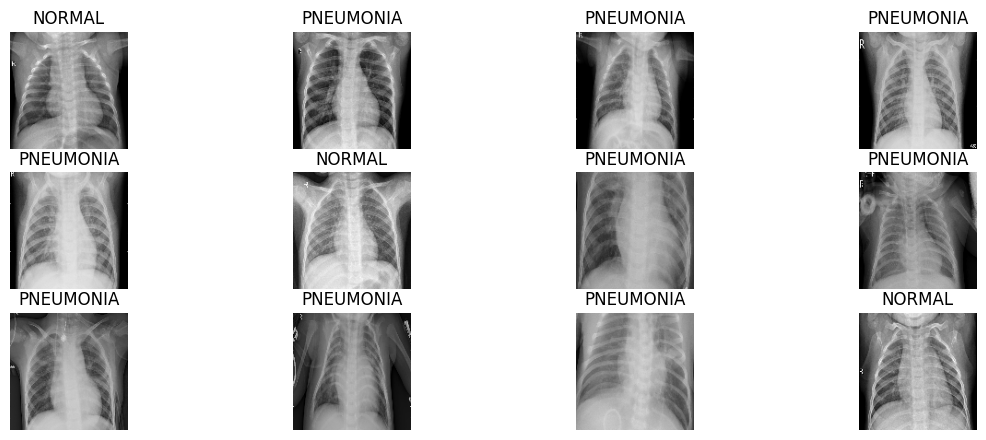

In [11]:
plt.figure(figsize=(14, 7))
for images, labels in train_ds.take(1):
    for i in range(12):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().squeeze(), cmap='gray')
        plt.title(class_names[labels[i].numpy()])
        plt.axis("off")
plt.show()

In [12]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)


In [13]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),

])
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))


In [14]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'valid' , activation = 'relu' , input_shape = (128,128,3)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'valid' , activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'valid' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'valid' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))

model.add(GlobalAveragePooling2D())
#GlobalAveragePooling2D()


model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(units = 32 , activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(units = 1 , activation = 'sigmoid'))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
model.compile(optimizer=Adam(learning_rate=1e-5), loss="binary_crossentropy", metrics=["accuracy"])


In [16]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 126, 126, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 126, 126, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 61, 61, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 61, 61, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 31, 31, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 29, 29, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 29, 29, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 29, 29, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 15, 15, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 13, 13, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 13, 13, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 13, 13, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │              

 Total params: 427,393 (1.63 MB)

 Trainable params: 426,433 (1.63 MB)

 Non-trainable params: 960 (3.75 KB)

In [17]:
history = model.fit(train_ds, validation_data=validation_ds , epochs=10)


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 56s 249ms/step - accuracy: 0.6668 - loss: 0.6465 - val_accuracy: 0.5000 - val_loss: 0.8374
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 73s 258ms/step - accuracy: 0.7515 - loss: 0.4865 - val_accuracy: 0.5000 - val_loss: 1.7771
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 41s 252ms/step - accuracy: 0.7896 - loss: 0.4309 - val_accuracy: 0.5000 - val_loss: 2.5383
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 82s 251ms/step - accuracy: 0.8231 - loss: 0.3857 - val_accuracy: 0.5000 - val_loss: 2.0610
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 41s 253ms/step - accuracy: 0.8311 - loss: 0.3596 - val_accuracy: 0.5000 - val_loss: 1.7854
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 81s 250ms/step - accuracy: 0.8491 - loss: 0.3459 - val_accuracy: 0.5000 - val_loss: 1.3729
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 42s 258ms/step - accuracy: 0.8551 - loss: 0.3324 - val_accuracy: 0.5000 - val_loss: 1.1064
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 82s 256ms/step - accuracy: 0.8490 - loss: 0

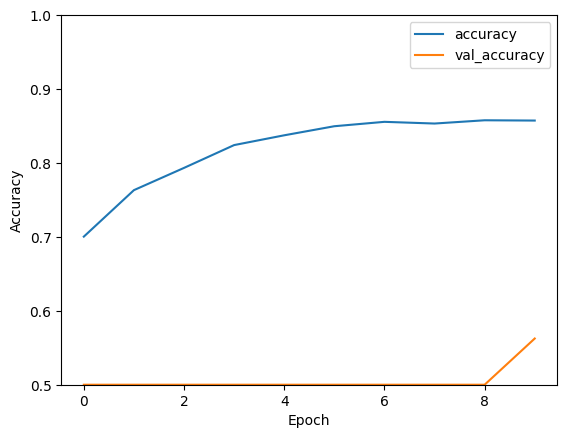

In [18]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend()

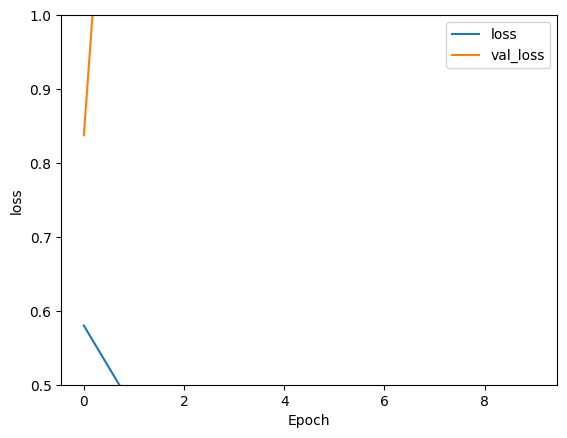

In [19]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.ylim([0.5, 1])
plt.legend()

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step


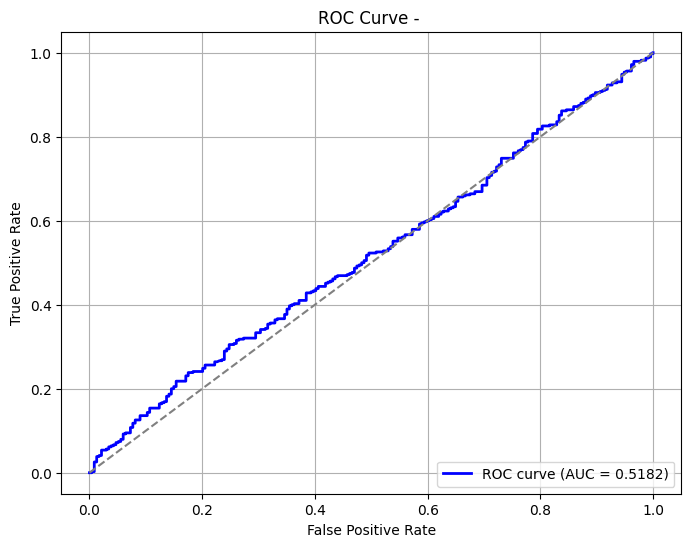

In [23]:

test_ds_resized = test_ds.map(lambda x, y: (tf.image.resize(x,model.input_shape[1:3]), y))

# Get true labels from test dataset
y_true = np.concatenate([y for x, y in test_ds], axis=0)

# Get predicted probabilities from the best model
y_pred_prob = model.predict(test_ds_resized)

# Compute ROC curve and AUC score
fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve - ')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [24]:
import numpy as np
from sklearn.metrics import accuracy_score

y_true = []
for images, labels in test_ds:
    y_true.extend(labels.numpy())

y_true = np.array(y_true)

y_pred = model.predict(test_ds)
y_pred = np.round(y_pred).flatten()
accuracy = accuracy_score(y_true, y_pred)

print(f"✅ Test Accuracy: {accuracy * 100:.2f}%")


20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 202ms/step
✅ Test Accuracy: 54.97%


🚀 Training MobileNetV2...
Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 57s 284ms/step - accuracy: 0.8519 - loss: 0.3373 - val_accuracy: 0.8125 - val_loss: 0.3309 - learning_rate: 0.0010
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 77s 284ms/step - accuracy: 0.9029 - loss: 0.2205 - val_accuracy: 0.8125 - val_loss: 0.4466 - learning_rate: 0.0010
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 82s 282ms/step - accuracy: 0.9171 - loss: 0.2000 - val_accuracy: 0.8125 - val_loss: 0.3969 - learning_rate: 0.0010
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.9356 - loss: 0.1708
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
163/163 ━━━━━━━━━━━━━━━━━━━━ 82s 282ms/step - accuracy: 0.9356 - loss: 0.1708 - val_accuracy: 0.8125 - val_loss: 0.4031 - learning_rate: 0.0010
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 47s 288ms/step - accuracy: 0.9288 - loss: 0.1769 - val_accuracy: 0.8125 - val_loss: 0.3761 - learning_rate: 2.0000e-04
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 4

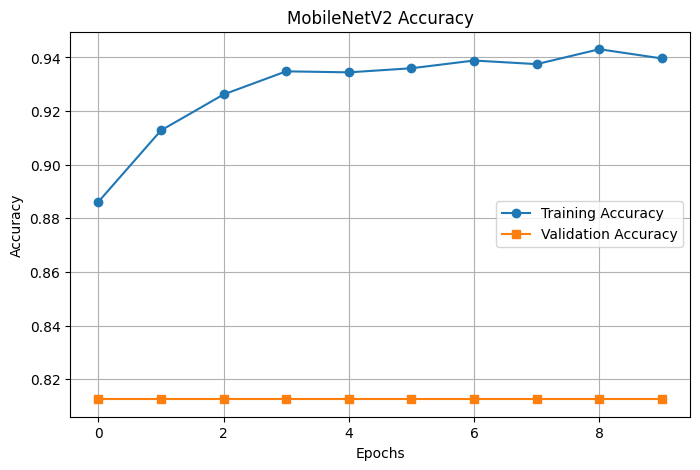

20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 83ms/step - accuracy: 0.8108 - loss: 0.4520
✅ MobileNetV2 - Test Accuracy: 0.8317
🚀 Training EfficientNetB0...
Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 72s 308ms/step - accuracy: 0.7190 - loss: 0.5988 - val_accuracy: 0.5000 - val_loss: 0.9017 - learning_rate: 0.0010
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 68s 289ms/step - accuracy: 0.7413 - loss: 0.5814 - val_accuracy: 0.5000 - val_loss: 0.8379 - learning_rate: 0.0010
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 45s 275ms/step - accuracy: 0.7429 - loss: 0.5772 - val_accuracy: 0.5000 - val_loss: 0.8622 - learning_rate: 0.0010
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 48s 290ms/step - accuracy: 0.7397 - loss: 0.5850 - val_accuracy: 0.5000 - val_loss: 0.8242 - learning_rate: 0.0010
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 80s 281ms/step - accuracy: 0.7396 - loss: 0.5817 - val_accuracy: 0.5000 - val_loss: 0.8572 - learning_rate: 0.0010
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 82s 283ms/step - accuracy: 0.7435 - loss: 0.

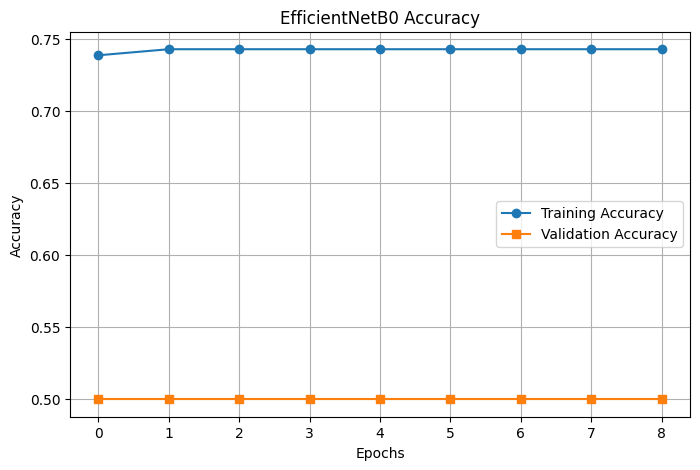

20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.6248 - loss: 0.6935
✅ EfficientNetB0 - Test Accuracy: 0.6250
🚀 Training InceptionV3...
Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 70s 332ms/step - accuracy: 0.8015 - loss: 0.4428 - val_accuracy: 0.6250 - val_loss: 0.6576 - learning_rate: 0.0010
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 53s 320ms/step - accuracy: 0.9059 - loss: 0.2211 - val_accuracy: 0.7500 - val_loss: 0.5858 - learning_rate: 0.0010
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 84s 332ms/step - accuracy: 0.9164 - loss: 0.2067 - val_accuracy: 0.6250 - val_loss: 0.5390 - learning_rate: 0.0010
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 51s 312ms/step - accuracy: 0.9252 - loss: 0.1757 - val_accuracy: 0.6875 - val_loss: 0.6513 - learning_rate: 0.0010
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 52s 319ms/step - accuracy: 0.9225 - loss: 0.1837 - val_accuracy: 0.7500 - val_loss: 0.7127 - learning_rate: 0.0010
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - accuracy: 0.9254 - loss: 0.1

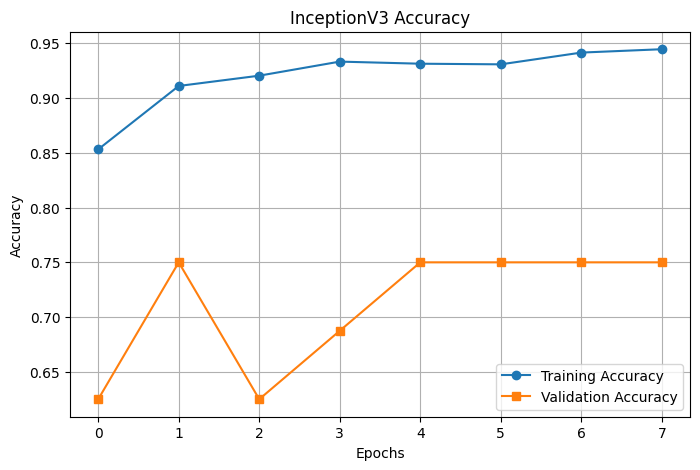

20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 118ms/step - accuracy: 0.8225 - loss: 0.3801
✅ InceptionV3 - Test Accuracy: 0.8221
🚀 Training ResNet50...
Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 66s 317ms/step - accuracy: 0.7330 - loss: 0.5905 - val_accuracy: 0.5000 - val_loss: 0.9606 - learning_rate: 0.0010
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 74s 314ms/step - accuracy: 0.7435 - loss: 0.5565 - val_accuracy: 0.5000 - val_loss: 0.7978 - learning_rate: 0.0010
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 81s 312ms/step - accuracy: 0.7398 - loss: 0.5386 - val_accuracy: 0.5000 - val_loss: 0.7507 - learning_rate: 0.0010
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 53s 324ms/step - accuracy: 0.7493 - loss: 0.5058 - val_accuracy: 0.5000 - val_loss: 0.8304 - learning_rate: 0.0010
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 51s 312ms/step - accuracy: 0.7597 - loss: 0.4901 - val_accuracy: 0.5625 - val_loss: 0.6913 - learning_rate: 0.0010
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 82s 315ms/step - accuracy: 0.7584 - loss: 0.4793 

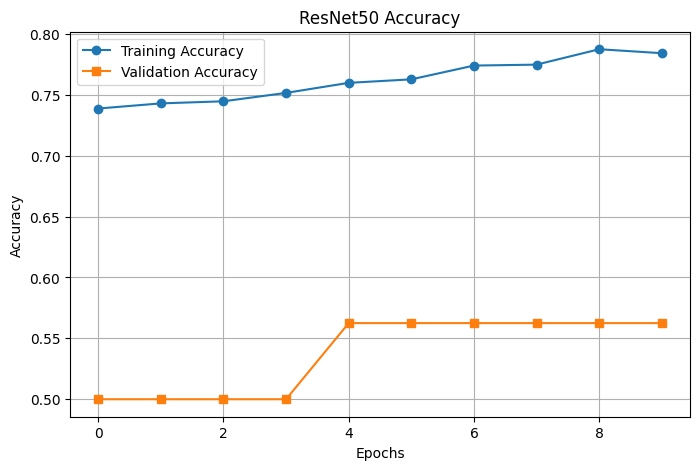

20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step - accuracy: 0.7007 - loss: 0.5483
✅ ResNet50 - Test Accuracy: 0.7099
🏆 Best Model: MobileNetV2 with Validation Accuracy: 0.8125


In [30]:
models_dict = {
    "MobileNetV2": {"fn": MobileNetV2, "input_shape": (128, 128, 3)},
    "EfficientNetB0": {"fn": EfficientNetB0, "input_shape": (128, 128, 3)},
    "InceptionV3": {"fn": InceptionV3, "input_shape": (299, 299, 3)},
    "ResNet50": {"fn": ResNet50, "input_shape": (224, 224, 3)}  # Changed input shape to (224, 224, 3)
}


early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)
callbacks = [early_stopping, reduce_lr]

history_dict = {}
best_val_acc = 0.0

for name, model_info in models_dict.items():
    print(f"🚀 Training {name}...")

    base_model = model_info["fn"](include_top=False, input_shape=model_info["input_shape"], weights="imagenet")
    base_model.trainable = False

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(128, activation="relu"),
        Dropout(0.3),
        Dense(1, activation="sigmoid")
    ])

    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

    if name == "ResNet50" or name == "InceptionV3": # Only resize if using ResNet50 or InceptionV3
        train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, model_info["input_shape"][:2]), y))
        validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, model_info["input_shape"][:2]), y))
        test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, model_info["input_shape"][:2]), y))

    else:
        train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, (128, 128)), y))
        validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, (128, 128)), y))
        test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, (128, 128)), y))



    history = model.fit(train_ds, validation_data=validation_ds, epochs=10, callbacks=callbacks)

    history_dict[name] = history.history

    plt.figure(figsize=(8, 5))
    plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='s')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title(f"{name} Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()


    max_val_acc = max(history.history['val_accuracy'])

    if max_val_acc > best_val_acc:
        best_val_acc = max_val_acc
        best_model = model
        best_model_name = name


    test_loss, test_acc = model.evaluate(test_ds)
    print(f"✅ {name} - Test Accuracy: {test_acc:.4f}")

print(f"🏆 Best Model: {best_model_name} with Validation Accuracy: {best_val_acc:.4f}")


20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 244ms/step


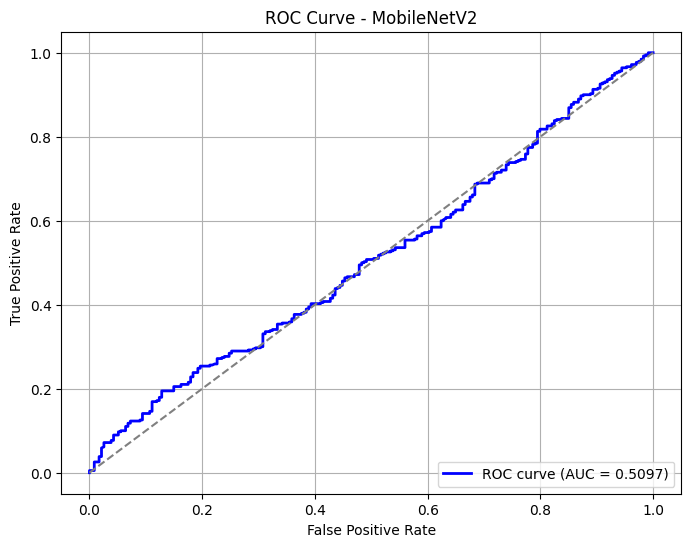

In [26]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
test_ds_resized = test_ds.map(lambda x, y: (tf.image.resize(x, best_model.input_shape[1:3]), y))

y_true = np.concatenate([y for x, y in test_ds], axis=0)

y_pred_prob = best_model.predict(test_ds_resized)

fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve - {best_model_name}')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [27]:
model.save("pneumonia_model.h5")
